In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#fatiando imports
from fatiando.gravmag import normal_gravity
from fatiando import gridder, utils, mesher
from fatiando.gravmag import polyprism, prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv

In [2]:
#densidade crosta continental
rho_c = 2.67
# densidade manto
rho_m = 3.33
# densidade agua
rho_w = 1.0

In [78]:
#comprimento total da area com topografia
compr = 500.E3
step = 10.E3
# criacao do grid com os valores
xp = np.arange(-compr/2., compr/2., 10.E3)
yp = np.arange(-compr/2., compr/2., 10.E3)
xv, yv = np.meshgrid(xp, yp)

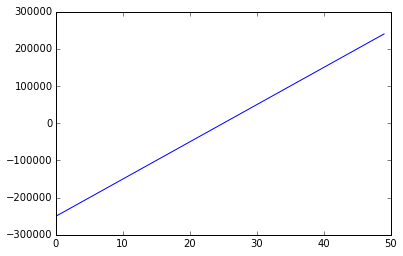

In [65]:
plt.figure()
plt.plot(xv[1,:])

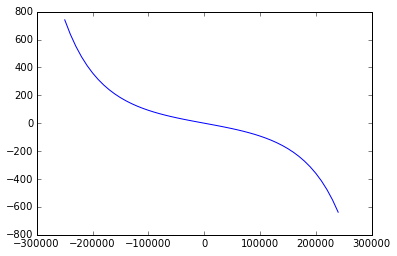

In [132]:
#zv = np.zeros(xv.shape)

sigma = 0.6
x_ = xv/(compr/2)
zv = 100*(x_/(np.sqrt(2*3.14)*sigma**3))*np.exp( x_**2/(2*sigma**2) )
plt.figure()
# plot com -zv porque zv>0 aponta para baixo, subsuperficies
plt.plot(xv[1,:],-zv[1,:])

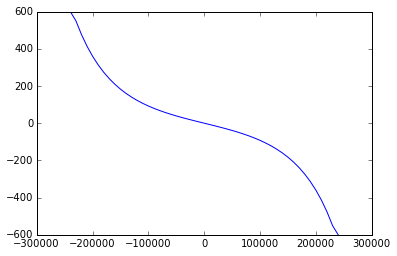

In [134]:
# colocando um topo e um fundo para a topografia
z_ = zv
z_[z_>600] = 600.
z_[z_<-600] = -600
plt.figure()
plt.plot(xv[1,:],-zv[1,:])

In [141]:
# profundidade moho
dmoho = 30.E3
########
rhocont = rho_c - rho_m
rhoocean = rho_m-rho_c
prism_list=[]
for i in range(z_.shape[0]):
    for j in range(z_.shape[1]):
        if z_[i,j] <= 0.:
            # espessura para compensar a topografia terrestre
            r1 = -z_[i,j]*rho_c/(rho_m-rho_c)
            rho = rhocont
            prism_calc = p_continent = Prism(xv[i,j] - step/2, xv[i,j] + step/2,
                                             yv[i,j] - step/2, yv[i,j] + step/2,
                                             dmoho, dmoho + r1 , {'density':rhocont})
        if z_[i,j] > 0.:
            # espessura para compensar oceano
            r2 = z_[i,j]*(rho_c - rho_w)/(rho_m - rho_c)
            rho = rhoocean
            prism_calc = p_continent = Prism(xv[i,j] - step/2, xv[i,j] + step/2,
                                             yv[i,j] - step/2, yv[i,j] + step/2,
                                             dmoho - r2, dmoho, {'density':rhoocean})
        prism_list.append(prism_calc)
    

In [158]:
len(prism_list)

2500

In [148]:
z_[1,1]

-600.0

In [157]:
prism_list[0].getvalue('density')

AttributeError: 'Prism' object has no attribute 'getvalue'

In [144]:
prism_list[0].get_bounds()

[-255000.0, -245000.0, -255000.0, -245000.0, 30000.0, 32427.272727272728]

In [146]:
prism_list[50].get_bounds()

[-255000.0, -245000.0, -245000.0, -235000.0, 30000.0, 32427.272727272728]

In [161]:
print('X->limite inferior', xp.min(), 'limite superior', xp.max(), 'passo=', step)
print('Y->limite inferior', xp.min(), 'limite superior', xp.max(), 'passo=', step)

('X->limite inferior', -250000.0, 'limite superior', 240000.0, 'passo=', 10000.0)
('Y->limite inferior', -250000.0, 'limite superior', 240000.0, 'passo=', 10000.0)


In [210]:
# grid onde sera calculado o valor da anomalia
xg = xv[5:-5,5:-5]
yg = yv[5:-5,5:-5]
topo = z_[5:-5,5:-5]

In [213]:
xg_ = xg.reshape(np.prod(xg.shape))
yg_ = yg.reshape(np.prod(yg.shape))
topo_ = topo.reshape(np.prod(topo.shape))

In [215]:
# altura da medicao
zp = -3.E3*np.ones(len(xg_))
# calculo nos pontos (xp,yp,zp) da componente z de g
bouguer = prism.gz(xg_, yg_, zp, prism_list)

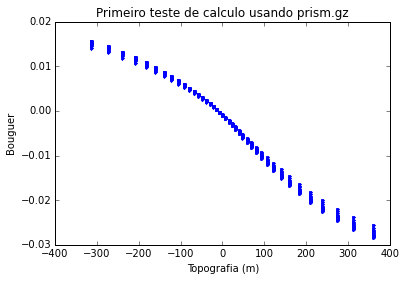

In [220]:
plt.figure()
plt.plot(-topo_,bouguer,'.')
plt.xlabel('Topografia (m)')
plt.ylabel('Bouguer')
plt.title('Primeiro teste de calculo usando prism.gz')

# Teste pegando uma linha para os valores calculados

In [224]:
xg2_ = xg[1,:]
yg2_ = yg[1,:]
topo_2 = -topo[1,:]
# altura da medicao
zp = -3.E3*np.ones(len(xg2_))
# calculo nos pontos (xp,yp,zp) da componente z de g
bouguer = prism.gz(xg2_, yg2_, zp, prism_list)

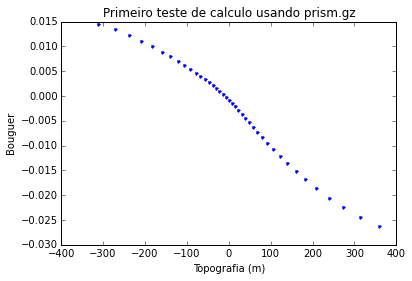

In [225]:
plt.figure()
plt.plot(topo_2,bouguer,'.')
plt.xlabel('Topografia (m)')
plt.ylabel('Bouguer')
plt.title('Primeiro teste de calculo usando prism.gz')

## Inicio calculo dos coeficientes para 'fitting'

In [226]:
topo_positive = topo_2[topo_2 >= 0]
topo_negative = topo_2[topo_2 < 0]

In [228]:
jacobian = np.zeros([len(bouguer),2])
jacobian[topo_2 < 0, 0] = topo_negative
jacobian[topo_2 >= 0, 1] = topo_positive

In [229]:
y = bouguer

In [230]:
result=[]
weight = np.eye(len(y),len(y))
for i in range(10):
    aest = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
    result.append(aest)
    weight = np.zeros([len(y),len(y)])
    np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [231]:
result

[array([ -5.16816350e-05,  -8.38808558e-05]),
 array([ -5.19799077e-05,  -8.52533384e-05]),
 array([ -5.23905351e-05,  -8.62157020e-05]),
 array([ -5.28381123e-05,  -8.64117075e-05]),
 array([ -5.32000098e-05,  -8.66710349e-05]),
 array([ -5.32789671e-05,  -8.69868415e-05]),
 array([ -5.32769978e-05,  -8.73439258e-05]),
 array([ -5.32751375e-05,  -8.77219509e-05]),
 array([ -5.32733811e-05,  -8.80973187e-05]),
 array([ -5.32717237e-05,  -8.84432991e-05])]

In [233]:
y_calc = np.zeros([len(bouguer)])
y_calc[topo_2 < 0] = result[9][0]*topo_negative
y_calc[topo_2 >= 0] = result[9][1]*topo_positive

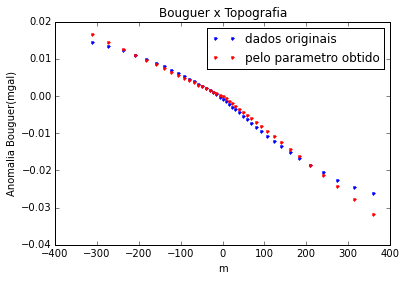

In [234]:
plt.figure()
plt.plot(topo_2,bouguer,'.',label='dados originais')
plt.plot(topo_2,y_calc,'.r',label='pelo parametro obtido')
plt.title('Bouguer x Topografia')
plt.xlabel('m')
plt.ylabel('Anomalia Bouguer(mgal)')
plt.legend()